# Introduction

The goal of this project is to accurately predict the policies that are most likely to be canceled and those most likely to be renewed, as well as understand what variables are most influential in causing a policy cancellation.

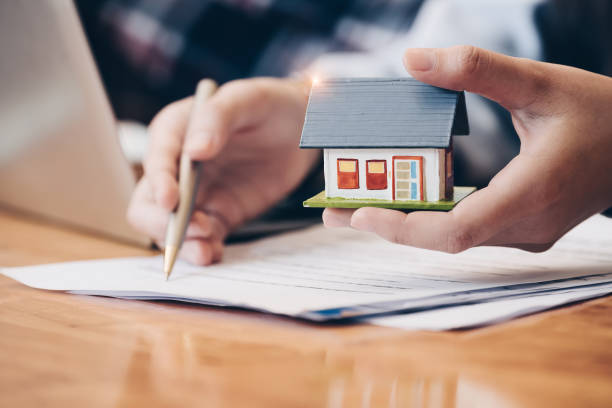

The project is aimed at predicting the policy cancellations at a property insurance company. The goal was to identify the most influential variables in causing policy cancellations and create a model that could accurately predict whether a policy would be cancelled or not.

We performed extensive exploratory data analysis, data cleaning, and feature engineering to prepare the data for modeling. The models we tested include decision tree, random forest, and gradient boosting. Since the data is big and imbalanced, we used random undersampler stratified by the target to train the model. Finally, we used permutation importance and partial dependence plots to interpret the results and identify the most important variables in predicting policy cancellations.

The rationale behind doing this project is to provide insights and recommendations to Kangaroo. It can use this model to position its marketing strategy that is more focused on winning back the lost clients to minimize losses. 

# Importing modules

In [80]:
# Data manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer

# Imputing states by zip code
!pip install uszipcode
from uszipcode import SearchEngine

# Scaling
from sklearn.preprocessing import StandardScaler

# Balancing the training 
!pip install imblearn
from imblearn.under_sampling import RandomUnderSampler

# Modeling
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Performance metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import f1_score

# Variable importance
from sklearn.inspection import permutation_importance


[notice] A new release of pip is available: 23.1 -> 23.1.2
[notice] To update, run: python3.10 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.1 -> 23.1.2
[notice] To update, run: python3.10 -m pip install --upgrade pip


In [81]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=UserWarning)

# Reading the datasets

In [82]:
# https://drive.google.com/file/d/1cF4YgsHb6jWoM8s1oMckCE5DXz71dJIr/view?usp=share_link
# https://drive.google.com/file/d/1k8asF0dptYNn1DFkylSEpr0D9FstpIO4/view?usp=share_link
# https://drive.google.com/file/d/1nldFnY3-FBKDvfpyLXjD9uxm7d7SLo6n/view?usp=share_link
# https://drive.google.com/file/d/1VirvGGFaqg1ifPjgO0MzHg3Bc7KuwotG/view?usp=share_link

# !gdown 1cF4YgsHb6jWoM8s1oMckCE5DXz71dJIr
# !gdown 1k8asF0dptYNn1DFkylSEpr0D9FstpIO4
# !gdown 1nldFnY3-FBKDvfpyLXjD9uxm7d7SLo6n
# !gdown 1VirvGGFaqg1ifPjgO0MzHg3Bc7KuwotG

In [83]:
# Reading datasets
X_test = pd.read_csv('/Users/yuxinzhang/Documents/Grad/Spring 2023/OPIM_5512/project_insuranceclaims_DS/raw_data/X_test.csv')
X_train = pd.read_csv('/Users/yuxinzhang/Documents/Grad/Spring 2023/OPIM_5512/project_insuranceclaims_DS/raw_data/X_train.csv')
y_test = pd.read_csv('/Users/yuxinzhang/Documents/Grad/Spring 2023/OPIM_5512/project_insuranceclaims_DS/raw_data/y_test.csv')
y_train = pd.read_csv('/Users/yuxinzhang/Documents/Grad/Spring 2023/OPIM_5512/project_insuranceclaims_DS/raw_data/y_train.csv')

In [84]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700232 entries, 0 to 700231
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 700232 non-null  int64  
 1   year               700232 non-null  int64  
 2   zip.code           699601 non-null  float64
 3   house.color        699612 non-null  object 
 4   ni.age             699524 non-null  float64
 5   len.at.res         699567 non-null  float64
 6   credit             699616 non-null  object 
 7   coverage.type      699569 non-null  object 
 8   dwelling.type      699581 non-null  object 
 9   premium            699608 non-null  float64
 10  sales.channel      699536 non-null  object 
 11  ni.gender          699589 non-null  object 
 12  ni.marital.status  699585 non-null  float64
 13  n.adults           699626 non-null  float64
 14  n.children         699616 non-null  float64
 15  tenure             699577 non-null  float64
 16  cl

In [85]:
X_train.describe()

,id,year,zip.code,ni.age,len.at.res,premium,ni.marital.status,n.adults,n.children,tenure,claim.ind
count,7.002320e+05,700232.000000,699601.000000,699524.000000,699567.000000,699608.000000,699585.000000,699626.000000,699616.000000,699577.000000,699574.000000
mean,5.242120e+05,2014.630125,62382.344581,43.563423,15.217011,899.980156,0.710736,2.133781,1.739503,11.681022,0.199133
std,3.027833e+05,1.111731,27985.075535,12.360499,4.566218,77.632340,0.453421,1.253179,2.342866,5.933411,0.399348
min,2.000000e+00,2013.000000,15001.000000,18.000000,1.000000,612.389520,0.000000,1.000000,0.000000,0.000000,0.000000
25%,2.622350e+05,2014.000000,50009.000000,35.000000,12.000000,844.024309,0.000000,1.000000,0.000000,6.000000,0.000000
50%,5.241605e+05,2015.000000,80011.000000,43.000000,15.000000,899.822849,1.000000,2.000000,1.000000,13.000000,0.000000
75%,7.867552e+05,2016.000000,85030.000000,51.000000,18.000000,955.452871,1.000000,3.000000,3.000000,16.000000,0.000000
max,1.048575e+06,2016.000000,98038.000000,389.478456,49.997586,1235.480942,1.000000,12.000000,12.000000,33.000000,1.000000


In [86]:
X_train.isna().sum()

id                     0
year                   0
zip.code             631
house.color          620
ni.age               708
len.at.res           665
credit               616
coverage.type        663
dwelling.type        651
premium              624
sales.channel        696
ni.gender            643
ni.marital.status    647
n.adults             606
n.children           616
tenure               655
claim.ind            658
dtype: int64

In [87]:
X_test.isna().sum()

id                     0
year                   0
zip.code             313
house.color          319
ni.age               293
len.at.res           295
credit               289
coverage.type        316
dwelling.type        339
premium              331
sales.channel        324
ni.gender            314
ni.marital.status    345
n.adults             323
n.children           319
tenure               323
claim.ind            324
dtype: int64

# Data Cleaning

## Dropping the id column

In [88]:
# dropping the id column
X_train = X_train.drop('id', axis = 1)
X_test = X_test.drop('id', axis = 1)

## Limit max of Age to 100



The max of Age is 389 which is not possible. Hence, we will limit the Age above 100 to 100.


In [89]:
X_train['ni.age'] = X_train['ni.age'].apply(lambda x: 100 if x > 100 else x)
X_test['ni.age'] = X_train['ni.age'].apply(lambda x: 100 if x > 100 else x)

## Removing missing values


In [90]:
print("Shape of training data", X_train.shape)
print("Shape of testing data", X_test.shape)

Shape of training data (700232, 16)
Shape of testing data (344891, 16)


## Encoding labels

In [91]:
# Imputing the missing values

# X_train
col_obj = X_train.select_dtypes(include='object').columns
col_num = X_train.select_dtypes(exclude='object').columns

# Impute the numeric values
for col in col_num:
    median = X_train[col].median()
    X_train[col].fillna(median, inplace=True)

for col in col_num:
    median = X_test[col].median()
    X_test[col].fillna(median, inplace=True) 

In [92]:
# Encode labels to object columns
le = LabelEncoder()

for col in col_obj:
    X_train[col] = le.fit_transform(X_train[col])

for col in col_obj:
    X_test[col] = le.fit_transform(X_test[col])

# Impute the categorical variables
imputer = KNNImputer(n_neighbors=3)
X_train[col_obj] = imputer.fit_transform(X_train[col_obj])
X_test[col_obj] = imputer.transform(X_test[col_obj])

## Check for missing values

In [93]:
# Check for missing values
print("Missing values in X_train:", X_train.isna().sum(),"\n")
print("Missing values in X_test:", X_test.isna().sum())

Missing values in X_train: year                 0
zip.code             0
house.color          0
ni.age               0
len.at.res           0
credit               0
coverage.type        0
dwelling.type        0
premium              0
sales.channel        0
ni.gender            0
ni.marital.status    0
n.adults             0
n.children           0
tenure               0
claim.ind            0
dtype: int64 

Missing values in X_test: year                 0
zip.code             0
house.color          0
ni.age               0
len.at.res           0
credit               0
coverage.type        0
dwelling.type        0
premium              0
sales.channel        0
ni.gender            0
ni.marital.status    0
n.adults             0
n.children           0
tenure               0
claim.ind            0
dtype: int64


# Feature engineering

## Creating interactions



*   Coverage * Dwelling
*   Tenure * Credit History
*   Length at residence * Credit


In [94]:
# Training set
X_train['coverage_dwelling'] = X_train['coverage.type'] * X_train['dwelling.type']
X_train['tenure_credit_history'] = X_train['tenure'] * X_train['credit']
X_train['res_credit'] = X_train['len.at.res'] * X_train['credit'] 

# Testing set
X_test['coverage_dwelling'] = X_test['coverage.type'] * X_test['dwelling.type']
X_test['tenure_credit_history'] = X_test['tenure'] * X_test['credit']
X_test['res_credit'] = X_test['len.at.res'] * X_test['credit'] 

## Deriving new features



*   Number of people in family = Adults + Children
*   Premium per person = Premium / Adults
*   Premium per family member = Premium / Number of people in family
*   Time elapsed for the policy = 2022 - Year




In [95]:
# Training set
X_train['n.people'] = X_train['n.adults'] + X_train['n.children']
X_train['premium_per_person'] = X_train['premium'] / X_train['n.adults']
X_train['premium_per_fmember'] = X_train['premium'] / X_train['n.people']
X_train['time_elapsed'] = 2022 - X_train['year']

# Testing set
X_test['n.people'] = X_test['n.adults'] + X_test['n.children']
X_test['premium_per_person'] = X_test['premium'] / X_test['n.adults']
X_test['premium_per_fmember'] = X_test['premium'] / X_test['n.people']
X_test['time_elapsed'] = 2022 - X_test['year']

## Binning Age and Tenure

In [96]:
# Create bins
age_bins = [0, 18, 35, 50, 100]
age_labels = ['Child', 'Adult', 'Middle-aged', 'Old']

# Applying the bins

## Training set
X_train['age_binned'] = pd.cut(X_train['ni.age'], bins=age_bins, labels=age_labels)
X_train['binned_tenure'] = pd.cut(X_train['tenure'], bins=3, labels=['short', 'medium', 'long'])

# Testing set
X_test['age_binned'] = pd.cut(X_test['ni.age'], bins=age_bins, labels=age_labels)
X_test['binned_tenure'] = pd.cut(X_test['tenure'], bins=3, labels=['short', 'medium', 'long'])

## Identify Variable State

In [97]:
# define function to search for state corresponding to zipcode
def get_state(zip_code):
    if zip_code and zip_code != '0':  # Add a conditional check for valid zip code
        result = search.by_zipcode(zip_code)
        if result is not None:
            return result.state
    return ''

In [98]:
# calling search engine
search = SearchEngine()
# vectorize the function
get_state = np.vectorize(get_state)

# create state cloumn for train set
X_train['zip.code'] = X_train['zip.code'].astype(int).astype(str)
X_train['State'] = get_state(X_train['zip.code'])

In [99]:
# create state column for test set
X_test['zip.code'] = X_test['zip.code'].astype(int).astype(str)
X_test['State'] = get_state(X_test['zip.code'])

In [100]:
X_train['zip.code'] = X_train['zip.code'].astype(int)
X_test['zip.code'] = X_test['zip.code'].astype(int)

## Saving the cleaned data as csv.

In [101]:
X_train.isna().sum()

year                     0
zip.code                 0
house.color              0
ni.age                   0
len.at.res               0
credit                   0
coverage.type            0
dwelling.type            0
premium                  0
sales.channel            0
ni.gender                0
ni.marital.status        0
n.adults                 0
n.children               0
tenure                   0
claim.ind                0
coverage_dwelling        0
tenure_credit_history    0
res_credit               0
n.people                 0
premium_per_person       0
premium_per_fmember      0
time_elapsed             0
age_binned               0
binned_tenure            0
State                    0
dtype: int64

In [102]:
X_train.nunique()

year                          4
zip.code                    310
house.color                   5
ni.age                       96
len.at.res                13838
credit                        4
coverage.type                 4
dwelling.type                 4
premium                  699496
sales.channel                 4
ni.gender                     3
ni.marital.status             2
n.adults                     12
n.children                   13
tenure                       34
claim.ind                     2
coverage_dwelling             7
tenure_credit_history        61
res_credit                 5335
n.people                     21
premium_per_person       699590
premium_per_fmember      699610
time_elapsed                  4
age_binned                    4
binned_tenure                 3
State                         6
dtype: int64

In [103]:
# X_train.to_csv("F:/MSDS/Data Science using Python/Project/X_train_clean.csv", index=False)
# X_test.to_csv("F:/MSDS/Data Science using Python/Project/X_test_clean.csv", index=False)

## Coding Dummy Variables

In [104]:
# # Cleaned X_train and X_test 
# # https://drive.google.com/file/d/1l0yE9LFhGAdAlIR3Uex9xpCv6wAg-ozd/view?usp=share_link
# # https://drive.google.com/file/d/1bPDDWgtJ83Rrlv9zSJjaNqGewT5ObHUq/view?usp=share_link

# !gdown 1l0yE9LFhGAdAlIR3Uex9xpCv6wAg-ozd
# !gdown 1bPDDWgtJ83Rrlv9zSJjaNqGewT5ObHUq

In [105]:
# X_test = pd.read_csv('X_test_clean.csv')
# X_train = pd.read_csv('X_train_clean.csv')

In [106]:
# identify non-numerical columns
non_number_col = X_train.select_dtypes(exclude = 'number').columns.tolist()
non_number_col

['age_binned', 'binned_tenure', 'State']

In [107]:
# one hot encode all non-numericla columns to dummy variables
X_train = pd.get_dummies(X_train, columns = non_number_col)

In [108]:
# performing the same prcoedure to the test set
non_number_col_2 = X_test.select_dtypes(include=['object', 'category']).columns.tolist()
X_test = pd.get_dummies(X_test, columns = non_number_col_2)

In [109]:
# quick look into the dataset structure
X_train.isna().sum()

year                      0
zip.code                  0
house.color               0
ni.age                    0
len.at.res                0
credit                    0
coverage.type             0
dwelling.type             0
premium                   0
sales.channel             0
ni.gender                 0
ni.marital.status         0
n.adults                  0
n.children                0
tenure                    0
claim.ind                 0
coverage_dwelling         0
tenure_credit_history     0
res_credit                0
n.people                  0
premium_per_person        0
premium_per_fmember       0
time_elapsed              0
age_binned_Child          0
age_binned_Adult          0
age_binned_Middle-aged    0
age_binned_Old            0
binned_tenure_short       0
binned_tenure_medium      0
binned_tenure_long        0
State_AZ                  0
State_CO                  0
State_IA                  0
State_PA                  0
State_VA                  0
State_WA            

Saving the columns names for labeling the permutation plot.

In [110]:
column_names = {index: column for index, column in enumerate(X_train.columns)}

Dropping the features that will not be used in the training.

In [111]:
# Dropping features
X_train = X_train.drop(["year", "ni.age", "tenure", "n.children"], axis=1)
X_test = X_test.drop(["year", "ni.age", "tenure", "n.children"], axis=1)

X_train.head(n=10)

,zip.code,house.color,len.at.res,credit,coverage.type,dwelling.type,premium,sales.channel,ni.gender,ni.marital.status,...,age_binned_Old,binned_tenure_short,binned_tenure_medium,binned_tenure_long,State_AZ,State_CO,State_IA,State_PA,State_VA,State_WA
0,15056,3.0,15.000000,0.0,0.0,1.0,935.554116,2.0,0.0,1.0,...,True,False,True,False,False,False,False,True,False,False
1,80014,1.0,17.000000,2.0,0.0,1.0,835.804218,2.0,0.0,1.0,...,True,False,True,False,False,True,False,False,False,False
2,85002,2.0,15.000000,0.0,0.0,0.0,958.488416,0.0,1.0,1.0,...,False,True,False,False,True,False,False,False,False,False
3,85051,1.0,15.000000,0.0,0.0,1.0,963.496010,2.0,0.0,1.0,...,True,False,True,False,True,False,False,False,False,False
4,85077,2.0,16.000000,0.0,1.0,1.0,803.088375,0.0,0.0,1.0,...,False,False,True,False,True,False,False,False,False,False
5,50020,3.0,2.409664,0.0,1.0,2.0,884.245436,0.0,1.0,1.0,...,False,True,False,False,False,False,True,False,False,False
6,15049,0.0,20.000000,0.0,2.0,0.0,1001.522320,2.0,0.0,1.0,...,False,True,False,False,False,False,False,True,False,False
7,50058,2.0,16.000000,1.0,0.0,1.0,935.903701,0.0,1.0,0.0,...,True,False,True,False,False,False,True,False,False,False
8,85072,1.0,14.000000,0.0,2.0,2.0,1041.835196,0.0,0.0,0.0,...,False,False,True,False,True,False,False,False,False,False
9,50057,0.0,15.000000,1.0,0.0,1.0,946.578875,0.0,1.0,1.0,...,False,False,True,False,False,False,True,False,False,False


# Visualizations

## Graphs

### Histogram


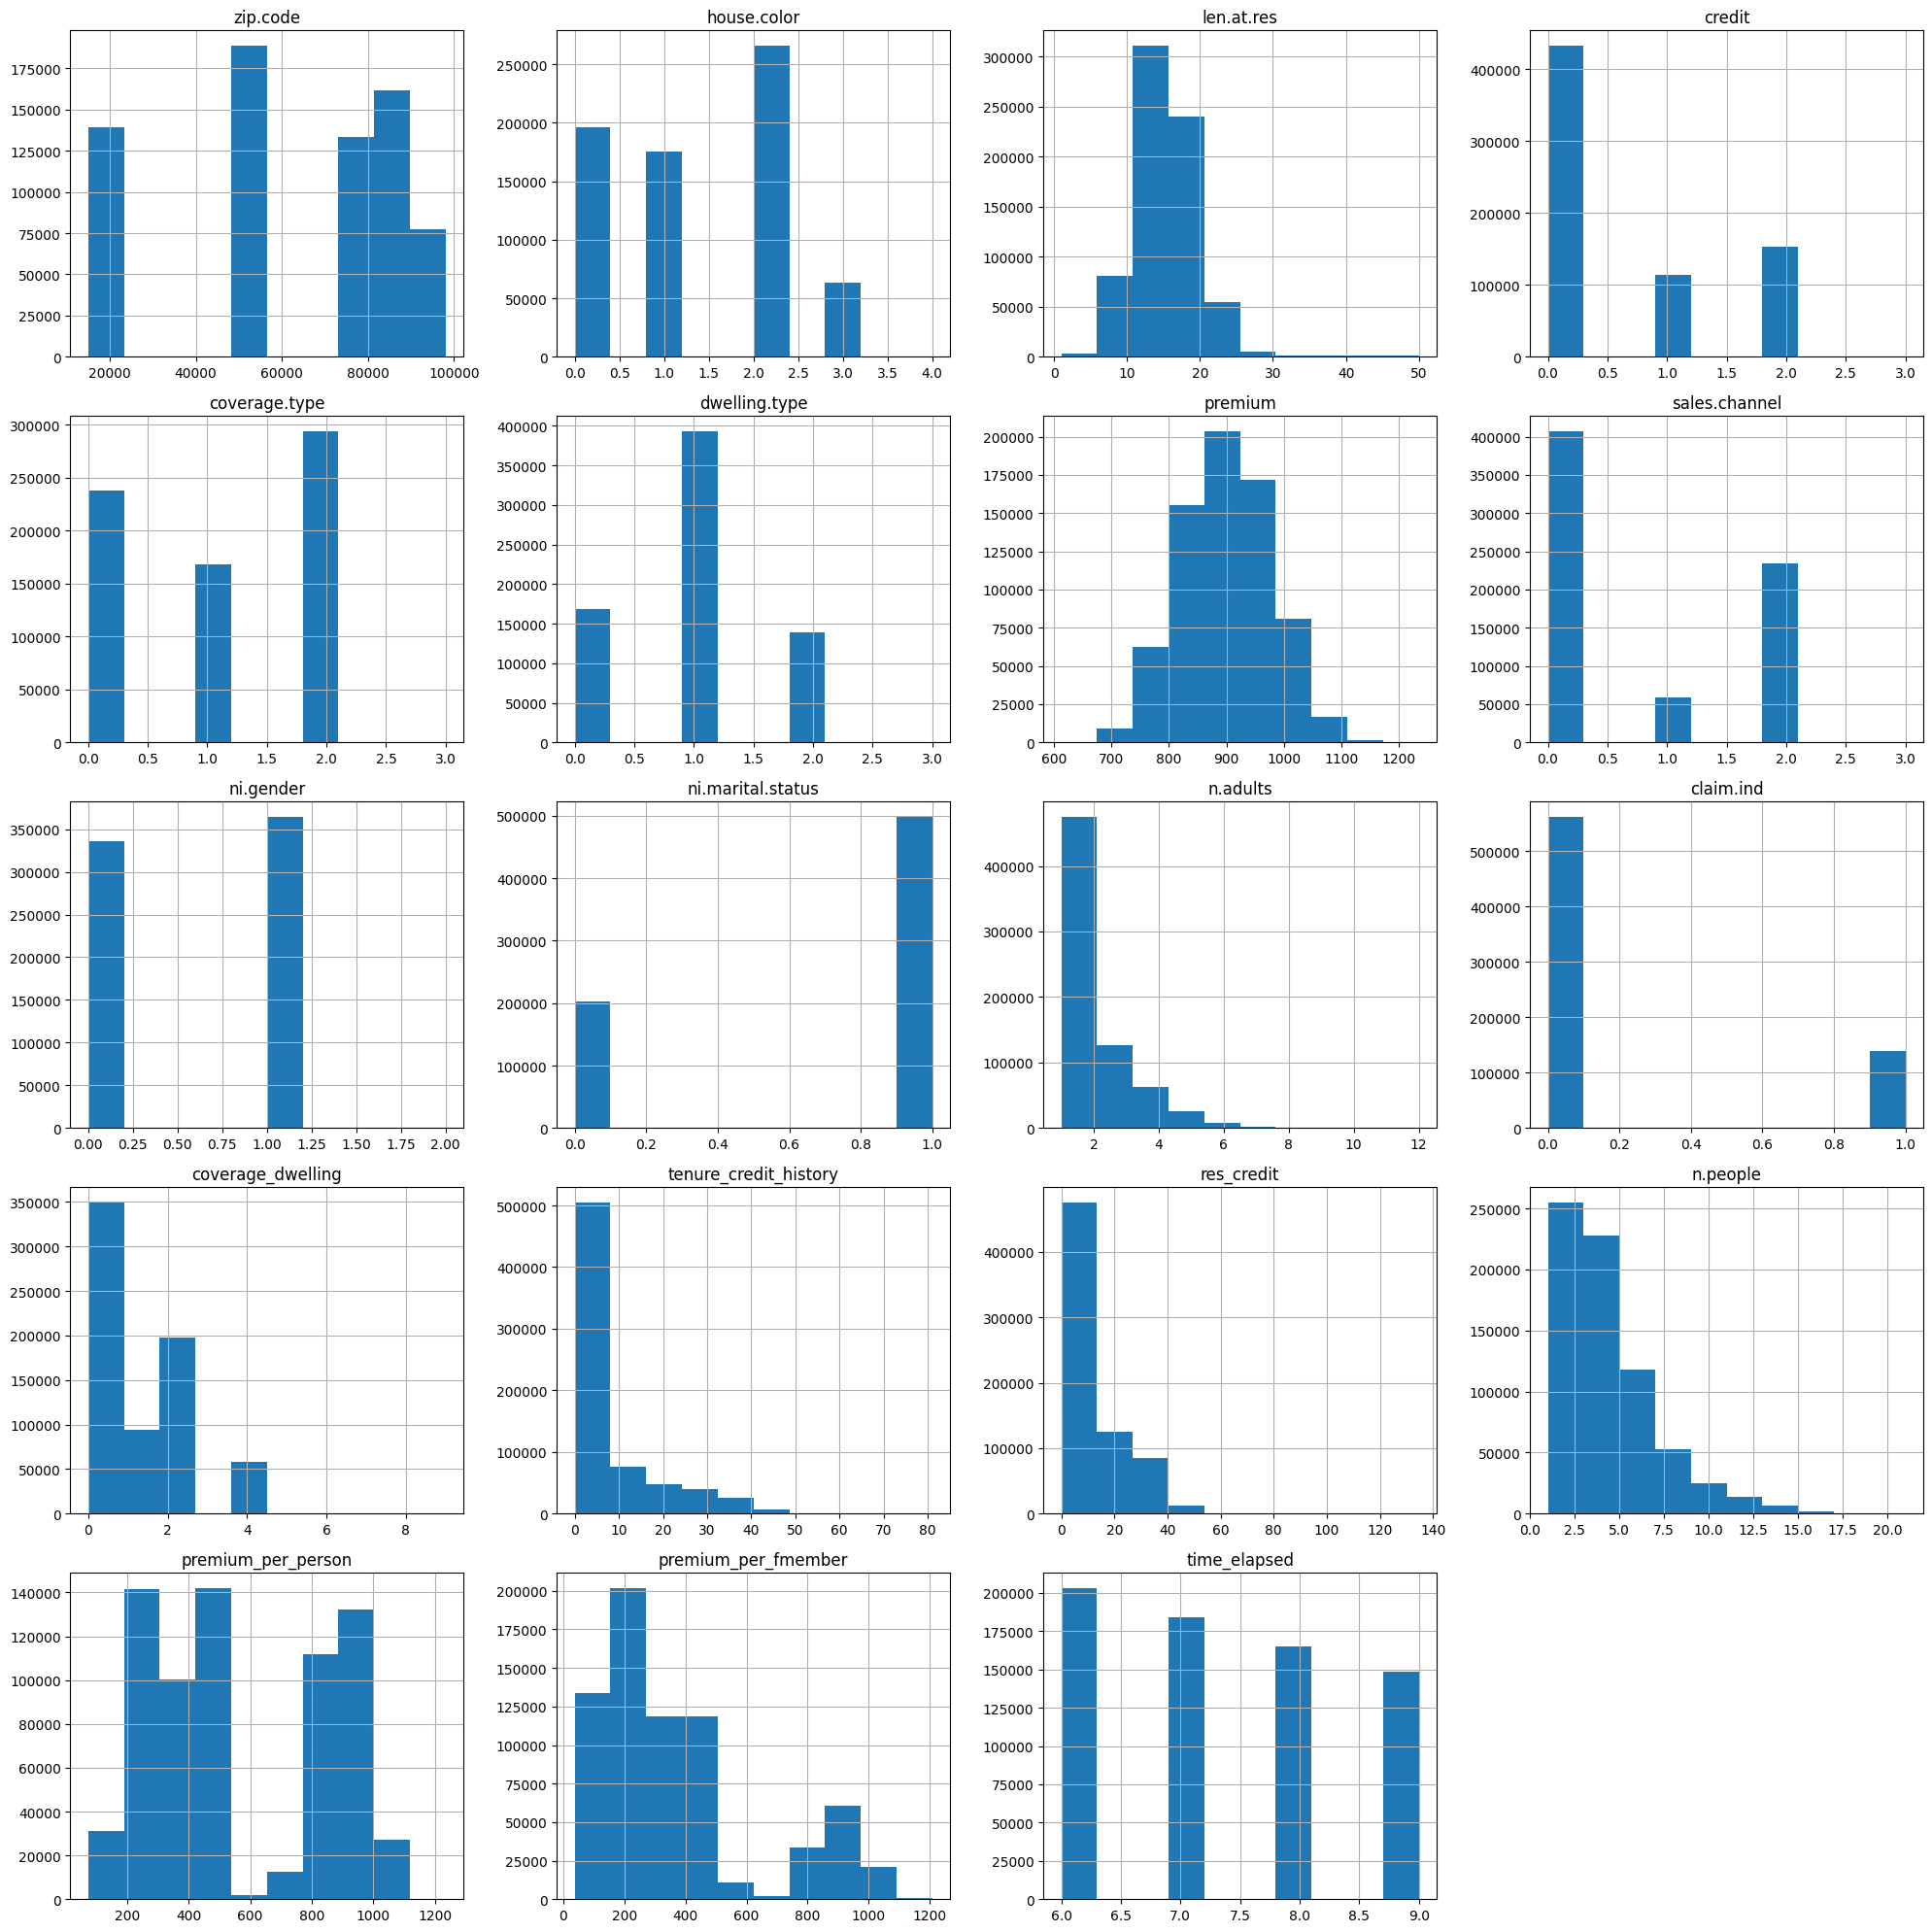

In [112]:
# dataframe histogram
X_train.hist()
plt.rcParams["figure.figsize"] = (20,20)
plt.tight_layout()
plt.show()

### Scatterplot

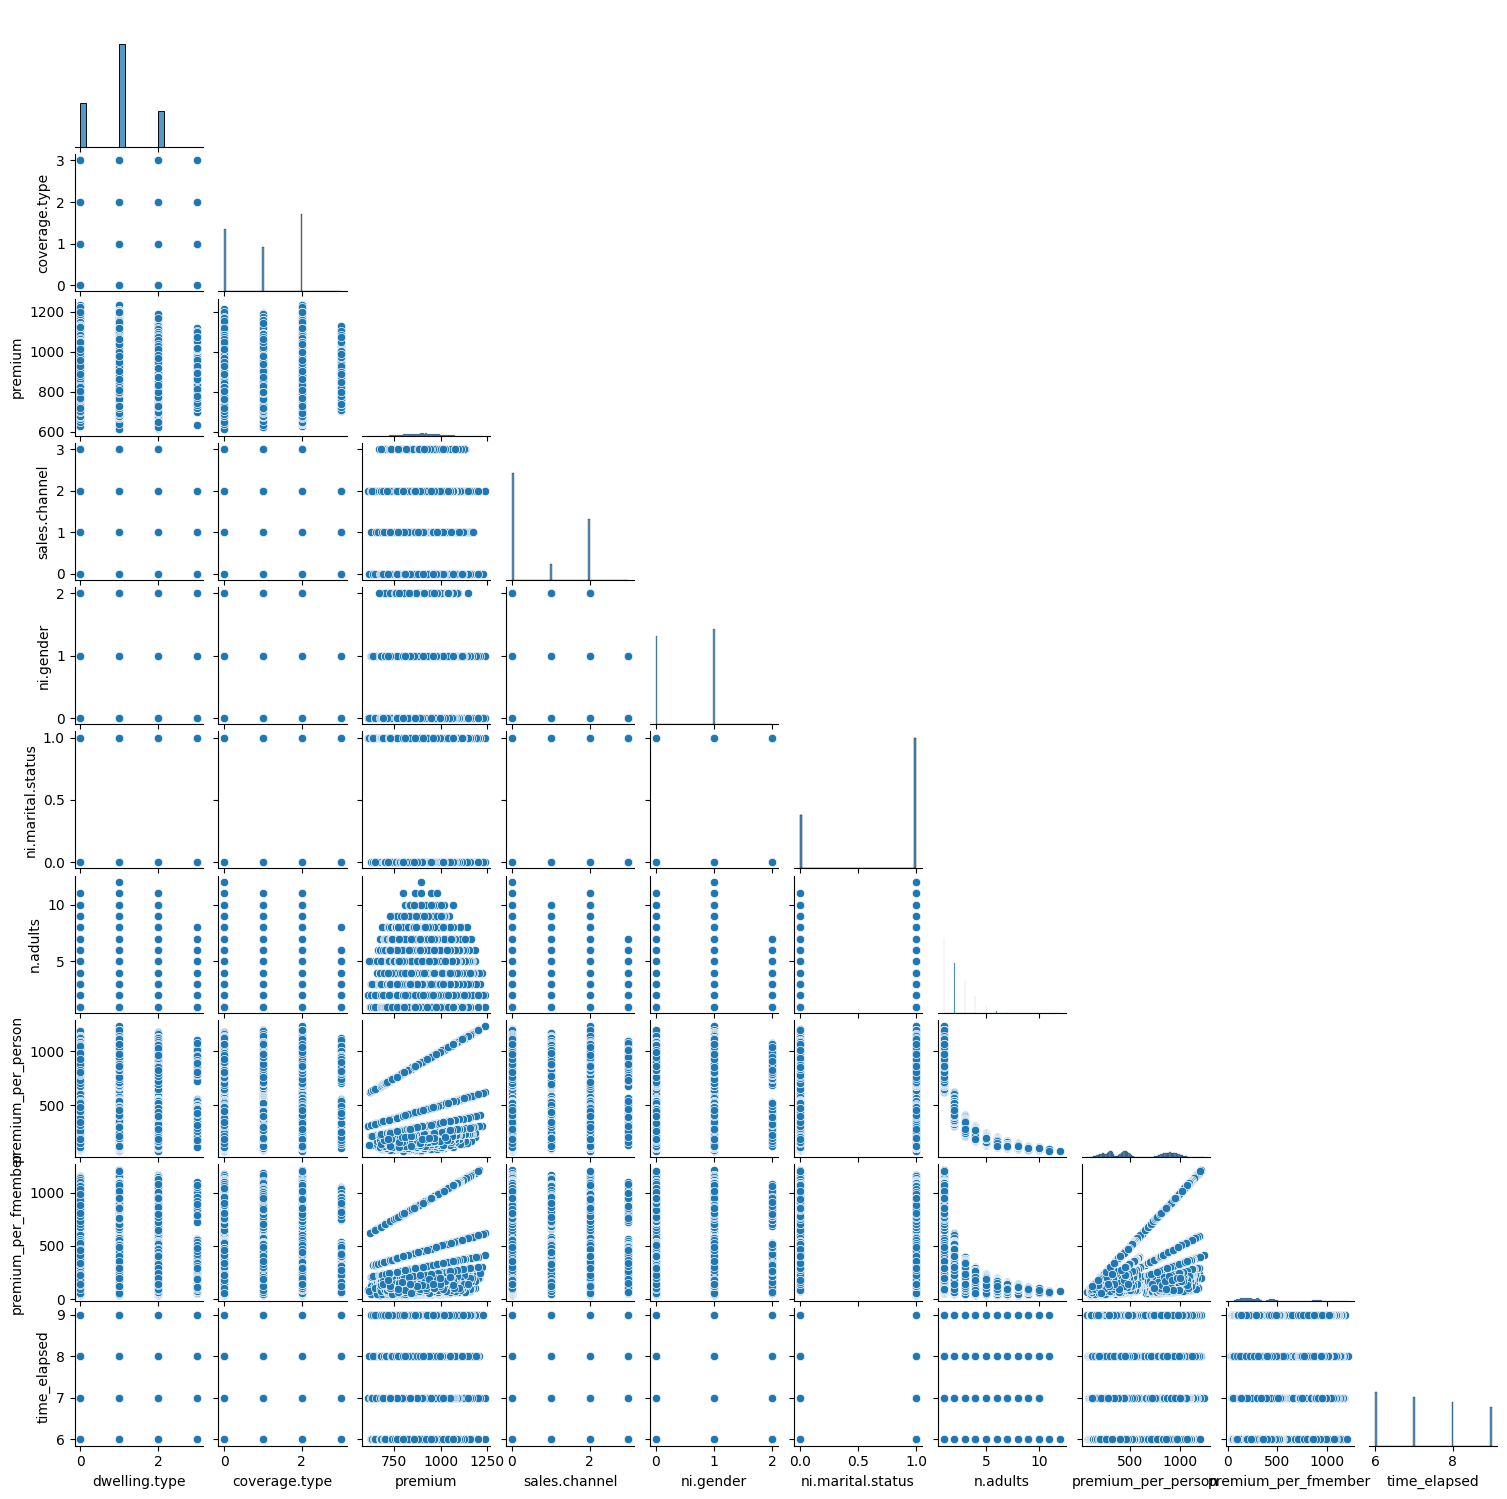

In [113]:
# scatterplot matrix
selected_columns = ['dwelling.type', 'coverage.type', 'premium', 'sales.channel', 'ni.gender', 
                   'ni.marital.status', 'n.adults', 'premium_per_person',
                   'premium_per_fmember', 'time_elapsed']
filtered_df = X_train[selected_columns]

sns.pairplot(filtered_df, diag_kind='hist', corner=True)
plt.gcf().set_size_inches(15, 15)

plt.show()

### Scatterplot of Premium by Credit, with Dwelling Type as the Color Indicator

<AxesSubplot: xlabel='credit', ylabel='premium'>

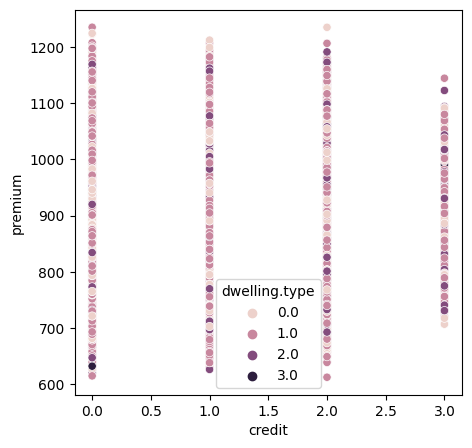

In [114]:
import matplotlib.pyplot as plt
import seaborn as sns

# scatterplot of credit vs premium by dwelling type 
plt.gcf().set_size_inches(5, 5)
sns.scatterplot(x = 'credit', y = 'premium', hue = 'dwelling.type', data = X_train)

### Histogram of Total People by Dwelling Type

Text(0.5, 1.0, 'Histogram of the Number of People by Dwelling Type')

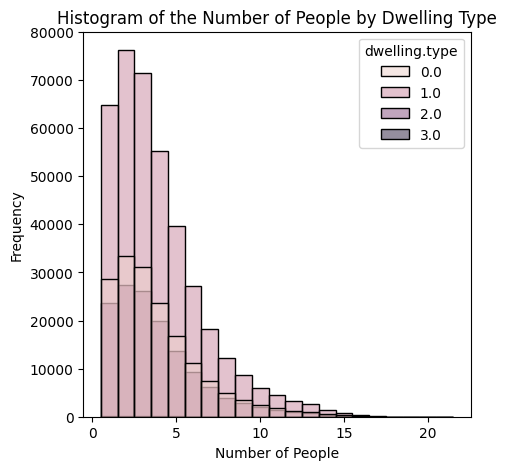

In [115]:
# histogram of total people with dwelling type
plt.gcf().set_size_inches(5, 5)
sns.histplot(X_train, x = 'n.people', hue = 'dwelling.type', discrete = True)
plt.xlabel('Number of People')
plt.ylabel('Frequency')
plt.title('Histogram of the Number of People by Dwelling Type')

### Correlation matrix

<AxesSubplot: >

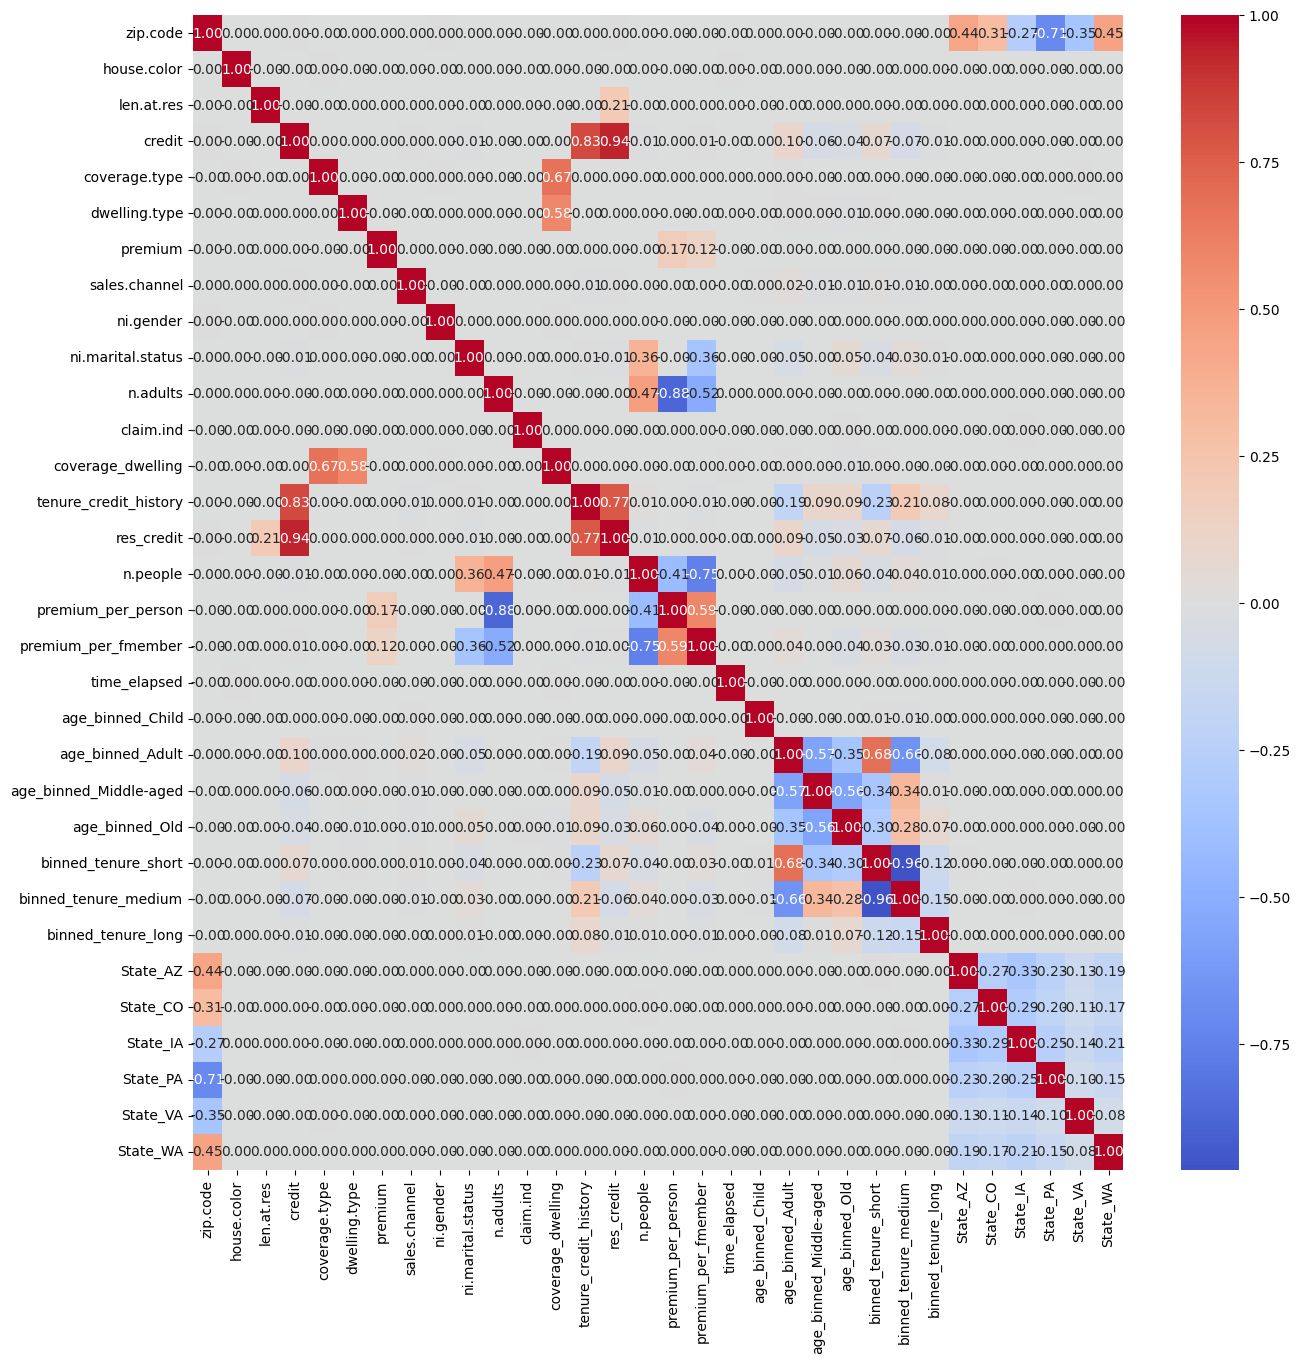

In [116]:
# Correlation Matrix
corr = X_train.corr()
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, ax=ax, fmt='.2f')

# Data Preprocessing

Standardizing the data.

In [117]:
# calling the scaler
scaler = StandardScaler()
# fit to train and then transform to both dataset
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# make train and test set dataframe
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

# quick investigation in the dataset after scaling
X_train.describe()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
count,7.002320e+05,7.002320e+05,7.002320e+05,7.002320e+05,7.002320e+05,7.002320e+05,7.002320e+05,7.002320e+05,7.002320e+05,7.002320e+05,...,7.002320e+05,7.002320e+05,7.002320e+05,7.002320e+05,7.002320e+05,7.002320e+05,7.002320e+05,7.002320e+05,7.002320e+05,7.002320e+05
mean,3.145647e-17,3.017791e-17,-1.025552e-15,7.520125e-17,-1.180531e-16,5.799659e-17,-4.523988e-15,-1.455318e-16,-1.038875e-16,1.153133e-16,...,8.666764e-17,6.759082e-17,1.064954e-17,-3.088822e-17,4.606850e-18,-8.320743e-19,-3.492175e-17,-5.513507e-17,5.054344e-17,-4.224299e-17
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.694123e+00,-1.317376e+00,-3.114953e+00,-7.298683e-01,-1.242785e+00,-1.447195e+00,-3.706174e+00,-8.149028e-01,-1.040535e+00,-1.568516e+00,...,-5.901417e-01,-8.739462e-01,-1.104125e+00,-1.338421e-01,-5.476388e-01,-4.854676e-01,-6.070387e-01,-4.192678e-01,-2.285433e-01,-3.518166e-01
25%,-4.428292e-01,-1.317376e+00,-7.048135e-01,-7.298683e-01,-1.242785e+00,5.967823e-02,-7.204558e-01,-8.149028e-01,-1.040535e+00,-1.568516e+00,...,-5.901417e-01,-8.739462e-01,-1.104125e+00,-1.338421e-01,-5.476388e-01,-4.854676e-01,-6.070387e-01,-4.192678e-01,-2.285433e-01,-3.518166e-01
50%,6.295346e-01,-2.897971e-01,-4.750267e-02,-7.298683e-01,-9.312145e-02,5.967823e-02,-2.025407e-03,-8.149028e-01,9.540226e-01,6.375453e-01,...,-5.901417e-01,-8.739462e-01,9.056949e-01,-1.338421e-01,-5.476388e-01,-4.854676e-01,-6.070387e-01,-4.192678e-01,-2.285433e-01,-3.518166e-01
75%,8.089291e-01,7.377815e-01,6.098081e-01,4.819904e-01,1.056542e+00,5.967823e-02,7.142422e-01,1.344026e+00,9.540226e-01,6.375453e-01,...,1.694508e+00,1.144235e+00,9.056949e-01,-1.338421e-01,-5.476388e-01,-4.854676e-01,1.647342e+00,-4.192678e-01,-2.285433e-01,-3.518166e-01
max,1.273875e+00,2.792939e+00,7.620595e+00,2.905708e+00,2.206206e+00,3.073424e+00,4.323594e+00,2.423490e+00,2.948580e+00,6.375453e-01,...,1.694508e+00,1.144235e+00,9.056949e-01,7.471491e+00,1.826021e+00,2.059870e+00,1.647342e+00,2.385110e+00,4.375539e+00,2.842390e+00


Over Sampling Dataset using SMOTE 

In [118]:
# Lets oversample the data
from imblearn.over_sampling import SMOTE

np.random.seed(123)
oversample = SMOTE(k_neighbors=9)
X_res, y_res = oversample.fit_resample(X_train, y_train) # change it later

# Model: Random Forest

## Grid Search
### On Samples of the Over Sampled Dataset

Random sampling 5 samples from the over Sampled Dataset, each with 10,000 observations. 

In [123]:
# setting a seed
np.random.seed(123457)

# combine the X_res and y_res for sampling process
sampling_df = pd.concat([X_res, y_res], axis = 1)

n_samples = 3 # number of samples we want
n = 5000 # number of observations we want for each sample
random_sample_list = [] 

# perform sampling process
for i in range(n_samples):
    random_indices = np.random.choice(sampling_df.index, size = n, 
                                      replace = False)
    random_sample = sampling_df.loc[random_indices]
    random_sample_list.append(random_sample)

Defining the parameter combinations for grid Search.

In [124]:
# Random Forest Classifier
RF = RandomForestClassifier(random_state = 198762)

clf2 = RF

#pipeline 
pipe_rf = Pipeline([('scaler',  StandardScaler()),
                    ('clf2', RandomForestClassifier(random_state=10))])

# paramaters in grid
param_grid_RF = [{
                  'clf2__n_estimators': [100, 200, 300], 
                  'clf2__max_depth': [5, 10, 20], 
                  'clf2__min_samples_split': [5, 10, 30],
                  'clf2__min_samples_leaf': [5, 10, 20],
                  
                  }] 

Defining the Grid Search.

In [125]:
# defining grid search
gs_rf = GridSearchCV(estimator = pipe_rf, param_grid = param_grid_RF, scoring = 'f1_macro', cv = 5)

performing the Grid Search.

In [126]:
# Grid Search Cross Validation

result = []

for j, random_sample in enumerate(random_sample_list):
    # to keep track of the training process
    print(f"Training random forest model on ramdom samples {j+1}...") 

    # extract features and target values
    X_sample = random_sample.drop(columns = ["cancel"])
    y_sample = random_sample["cancel"]

    # perform grid search
    gs_rf.fit(X_sample, y_sample)

    # evaluation
    pred = gs_rf.predict(X_test)

    # append results
    result.append({"samples":j+1, "prediction":pred})

Training random forest model on ramdom samples 1...
Training random forest model on ramdom samples 2...
Training random forest model on ramdom samples 3...


## Grid Search Result Display

Collect f1 score of test results.

In [127]:
predictions_rf = [r['prediction'] for r in result]

result_f1score_rf = []

# perform calculation for the f1_score
for i in range(len(predictions_rf)):
    y_pred = predictions_rf[i]
    f1 = f1_score(y_test, y_pred, average=None)

    result_f1score_rf.append(f1)

result_f1score_rf

[array([0.77092665, 0.30915949, 0.3987841 ]),
 array([0.76762664, 0.29911979, 0.40581899]),
 array([0.76929677, 0.30707283, 0.38033982])]

Obtain the average of f1 score of the test result.

In [128]:
# obtain mean of f1_score for each class across 30 samples
mean_0class_f1score_rf = np.mean([s[0] for s in result_f1score_rf])
mean_1class_f1score_rf = np.mean([s[1] for s in result_f1score_rf])
mean_2class_f1score_rf = np.mean([s[2] for s in result_f1score_rf])

print(f"Average f1_score for 0 class across 10 samples:", {mean_0class_f1score_rf}, "\n",
      "Average f1_score for 1 class across 10 samples:", {mean_1class_f1score_rf}, "\n",
      "Average f1_score for 2 class across 10 samples:", {mean_2class_f1score_rf})

Average f1_score for 0 class across 10 samples: {0.7692833519300125} 
 Average f1_score for 1 class across 10 samples: {0.3051173669752263} 
 Average f1_score for 2 class across 10 samples: {0.3949809664357533}


## Fitting the Model
### Fitting to the Over Sampled Dataset

In [129]:
# obtain the best parameter combination from grid search
best_params_rf = gs_rf.best_params_
print("Best parameter combination:", best_params_rf)

Best parameter combination: {'clf2__max_depth': 20, 'clf2__min_samples_leaf': 5, 'clf2__min_samples_split': 5, 'clf2__n_estimators': 300}


In [130]:
# Saving the best parameters separately for access
n_estimators_rf = best_params_rf['clf2__n_estimators']
max_depth_rf = best_params_rf['clf2__max_depth']
min_samples_leaf_rf = best_params_rf['clf2__min_samples_leaf']
min_samples_split_rf = best_params_rf['clf2__min_samples_split']

In [137]:
np.random.seed(123)
random_indices = np.random.choice(sampling_df.index, size = 500000, 
                                      replace = False)
random_sample = sampling_df.loc[random_indices]

X_sample = random_sample.drop(columns = ["cancel"])
y_sample = random_sample["cancel"]

In [138]:
# Fitting the random forest model
RF = RandomForestClassifier(random_state=432, n_estimators=n_estimators_rf, 
                            max_depth=max_depth_rf, min_samples_leaf=min_samples_leaf_rf,
                            min_samples_split=min_samples_split_rf)
RF.fit(X_sample, y_sample.values.ravel())

RandomForestClassifier(max_depth=20, min_samples_leaf=5, min_samples_split=5,
                       n_estimators=300, random_state=432)

In [139]:
# predict
prediction_rf = RF.predict(X_test)

In [140]:
# obtain classification report
report_rf = classification_report(y_test, prediction_rf)
print(report_rf)

              precision    recall  f1-score   support

           0       0.82      0.78      0.80    244522
           1       0.25      0.61      0.36     24772
           2       0.51      0.35      0.41     75597

    accuracy                           0.67    344891
   macro avg       0.53      0.58      0.52    344891
weighted avg       0.71      0.67      0.68    344891



## Permutation Importance Plot

In [ ]:
# permutation importance plot
clf = RF

result = permutation_importance(clf, X_test, y_test, n_repeats=10,
                                random_state=42)
perm_sorted_idx = result.importances_mean.argsort()

In [ ]:
# plotting the permutation importance plot.
fig, ax1 = plt.subplots(1, 1, figsize=(6, 4))
ax1.boxplot(result.importances[perm_sorted_idx].T, vert=False,
            labels=X_train.columns[perm_sorted_idx])
ax1.set_yticklabels(column_names[idx] for idx in perm_sorted_idx)
fig.suptitle('RF Feature Importance', y=1.05) 
fig.tight_layout()
plt.show()

## Partial Dependence Plot

In [ ]:
# Extracting top 5 features
top_5_features = X_train.columns[perm_sorted_idx][-5:][::-1]

train_X_df = pd.DataFrame(X_train, columns=X_train.columns)
train_X_df.head()

# Plots the grid of partial dependence plots of top features
def plot_ice_grid(dict_of_ice_dfs, data_df, features, ax_ylabel='', nrows=4, 
                  ncols=4, figsize=(12, 12), sharex=False, sharey=True,
                  num_grid_points = 10, # DW added this on 4/27/2022! 
                  subplots_kws={}, rug_kws={'color':'k'}, **ice_plot_kws):
    """A function that plots ICE plots for different features in a grid."""
    fig, axes = plt.subplots(nrows=nrows, 
                             ncols=ncols, 
                             figsize=figsize,
                             sharex=sharex,
                             sharey=sharey,
                             **subplots_kws)
    # for each feature plot the ice curves and add a rug at the bottom of the 
    # subplot
    for f, ax in zip(features, axes.flatten()):
        ice_plot(dict_of_ice_dfs[f], ax=ax, **ice_plot_kws)
        # add the rug
        sns.distplot(data_df[f], ax=ax, hist=False, kde=False, 
                     rug=True, rug_kws=rug_kws)
        ax.set_title('feature = ' + f)
        ax.set_ylabel(ax_ylabel)
        sns.despine()
        
    # get rid of blank plots
    for i in range(len(features), nrows*ncols):
        axes.flatten()[i].axis('off')

    return fig

In [ ]:
# create dict of ICE data for grid of ICE plots
train_ice_dfs = {feat: ice(data=train_X_df, column=feat, predict=RF.predict) 
                 for feat in top_5_features}

plot_ice_grid(train_ice_dfs, train_X_df, top_5_features,
              ax_ylabel='Prediction', alpha=0.3, plot_pdp=True,
              pdp_kwargs={'c': 'red', 'linewidth': 3},
              linewidth=0.5, c='dimgray',
              num_grid_points=10)
plt.ylim([0,1])
plt.suptitle('ICE plots (training data): RF model')
plt.subplots_adjust(top=0.89)
plt.tight_layout()

# Conclusion

- Based on our analysis, the most influential variables in predicting the cancellation indicator were XXX, which suggests that these factors should be closely monitored by insurance companies to prevent cancellations.
- Considering the data is updated in real-time in today’s world, an interesting use of our classification model in property insurance industry would be to provide real-time policy cancellation predictions for customer service representatives. This would enable proactively reach out the clients to address their concerns to reduce the likelihood of policy cancellations.
- based on observation in the plots, the variation in the premium tend to remain roughly the same except for dwelling type 3. This indicates that dwelling type 3 consists of lower contribution to the dataset and generally has enjoyed a less varied premium. A closer look into the dataset reveals that we have an imbalanced data on the dwelling type.
- Considering the data is updated in real-time in today’s world, an interesting use of our classification model in property insurance industry would be to provide real-time policy cancellation predictions for customer service representatives. This would enable marketing to proactively reach out the clients to address their concerns and reduce the likelihood of policy cancellations.
- prediction for small probability event such as cancelation in comparison the rest enormous not-cancelation is difficult. This is close to anomaly detection yet given the amount of data it is still predictable. However, in our case, prediction measure is low and unreliable to make any meaningful decision.
- By the nature of the models of which we tried, random forests works the best. Decision tree tends to be weak on anomaly detection and hence the prediction result measure were low. XG-boost on the other hand tend to work well with smaller samples. However, on a enormous dataset such as the one we are working with, fitting can not only be extremely skewed but also be overfitting. That is, the model fits too well to the train set that performance on the test set is extremely low.

# Appendix

## Models:


1.   Decision Tree
2.   XG-Boost



## Decision Tree

### Grid Search

Preparing for the grid search cross validation.

In [ ]:
# define standard scaler
scaler = StandardScaler()

# set the tolerance to a large value to make the example faster
DT = DecisionTreeClassifier(random_state = 123457)

Define parameters for the grid search cross validation.

In [ ]:
# define model
clf = DT

# define pipepline
pipe_dt = Pipeline([('scaler', StandardScaler()),
			('clf', DecisionTreeClassifier(random_state=42))])

# define parameters in grid fasion
grid_params_dt = [{'clf__criterion': ['gini', 'entropy'],
                  'clf__min_samples_leaf': [10, 20, 25],
                  'clf__max_depth': [10, 15, 20],
                  'clf__min_samples_split': [10, 20, 25]}]

In [ ]:
# defining grid serach
gs_dt = GridSearchCV(estimator=pipe_dt,
    param_grid=grid_params_dt,
    scoring='f1_macro',
    cv=5)

Perform the grid search cross validation.

In [ ]:
result = []

for i, random_sample in enumerate(random_sample_list):
    # to keep track of the training process
    print(f"Training decision tree model on ramdom samples {i+1}...") 

    # extract features and target values
    X_sample = random_sample.drop(columns = ["cancel"])
    y_sample = random_sample["cancel"]

    # perform grid search
    gs_dt.fit(X_sample, y_sample)

    # evaluation
    pred = gs_dt.predict(X_test)

    # append results
    result.append({"samples":i+1, "prediction":pred})

### Grid Search Result Display

In [ ]:
# extract prediction 
predictions = [r['prediction'] for r in result]

In [ ]:
result_f1score = []

# perform calculation for the f1_score
for i in range(len(predictions)):
    y_pred = predictions[i]
    f1 = f1_score(y_test, y_pred, average=None)

    result_f1score.append(f1)

result_f1score

In [ ]:
# obtain mean of f1_score for each class across 30 samples
mean_0class_f1score = np.mean([s[0] for s in result_f1score])
mean_1class_f1score = np.mean([s[1] for s in result_f1score])
mean_2class_f1score = np.mean([s[2] for s in result_f1score])

print(f"Average f1_score for 0 class across 10 samples:", {mean_0class_f1score}, "\n",
      "Average f1_score for 1 class across 10 samples:", {mean_1class_f1score}, "\n",
      "Average f1_score for 2 class across 10 samples:", {mean_2class_f1score})

### Fitting the Model

In [ ]:
# identify the best parameter combination
best_params = gs_dt.best_params_

print("Best parameter combination:", best_params)

In [ ]:
criterion = best_params['clf__criterion']
max_depth = best_params['clf__max_depth']
min_samples_leaf = best_params['clf__min_samples_leaf']
min_samples_split = best_params['clf__min_samples_split']

In [ ]:
DT = DecisionTreeClassifier(random_state = 123457, criterion=criterion, max_depth = max_depth,
                             min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split)
DT.fit(X_train, y_train)

In [ ]:
prediction = DT.predict(X_test)

In [ ]:
report = classification_report(y_test, prediction)
print(report)

### Permutation Importance Plot

In [ ]:
# permutation importance plot
clf = DT

result = permutation_importance(clf, X_test, y_test, n_repeats=10,
                                random_state=42)
perm_sorted_idx = result.importances_mean.argsort()

In [ ]:
# plotting the permutation importance plot.
fig, ax1 = plt.subplots(1, 1, figsize=(6, 4))
ax1.boxplot(result.importances[perm_sorted_idx].T, vert=False,
            labels=X_train.columns[perm_sorted_idx])
ax1.set_yticklabels(column_names[idx] for idx in perm_sorted_idx)
fig.suptitle('DT Feature Importance', y=1.05) 
fig.tight_layout()
plt.show()

## XG-Boosting

### Grid Search

In [ ]:
# Gradient Boosting
GBC = GradientBoostingClassifier(random_state=4756)

clf3 = GBC

# pipeline
pipe_gb = Pipeline([('scaler',  StandardScaler()),
                    ('clf3', GradientBoostingClassifier(random_state=10))])

# Grid Search to find best hyperparameters (Commented out grid search because it requires time to run)
param_grid_gb = [{"clf3__learning_rate": [0.1],
              "clf3__n_estimators": [1000, 2000],
             "clf3__max_depth": [5, 7, 9],
             "clf3__min_samples_split": [5000, 7000, 9000],
              "clf3__subsample": [0.8],
              "clf3__max_features": ["sqrt"]}]

In [ ]:
# Defining grid search
gs_gb = GridSearchCV(estimator=pipe_gb, param_grid=param_grid_gb, scoring='f1_macro', cv=5)

In [ ]:
result = []

for i, random_sample in enumerate(random_sample_list):
    # to keep track of the training process
    print(f"Training gradient boosting model on ramdom samples {i+1}...") 

    # extract features and target values
    X_sample = random_sample.drop(columns = ["cancel"])
    y_sample = random_sample["cancel"]

    # perform grid search
    gs_gb.fit(X_sample, y_sample)

    # evaluation
    pred = gs_gb.predict(X_test)

    # append results
    result.append({"samples":i+1, "prediction":pred})

### Grid Search Result Display

In [ ]:
predictions_gb = [r['prediction'] for r in result]

result_f1score_gb = []

# perform calculation for the f1_score
for i in range(len(predictions_gb)):
    y_pred = predictions_gb[i]
    f1 = f1_score(y_test, y_pred, average=None)

    result_f1score_gb.append(f1)

result_f1score_gb

In [ ]:
# obtain mean of f1_score for each class across 30 samples
mean_0class_f1score_gb = np.mean([s[0] for s in result_f1score_gb])
mean_1class_f1score_gb = np.mean([s[1] for s in result_f1score_gb])
mean_2class_f1score_gb = np.mean([s[2] for s in result_f1score_gb])

print(f"Average f1_score for 0 class across 10 samples:", {mean_0class_f1score_gb}, "\n",
      "Average f1_score for 1 class across 10 samples:", {mean_1class_f1score_gb}, "\n",
      "Average f1_score for 2 class across 10 samples:", {mean_2class_f1score_gb})

### Fitting the Model

In [ ]:
best_params_gb = gs_gb.best_params_
print("Best parameter combination:", best_params_gb)

In [ ]:
learning_rate_gb = best_params_gb['clf3__learning_rate']
n_estimators_gb = best_params_gb['clf3__n_estimators']
max_depth_gb = best_params_gb['clf3__max_depth']
min_samples_split_gb = best_params_gb['clf3__min_samples_split']
subsample_gb = best_params_gb['clf3__subsample']
max_features_gb = best_params_gb['clf3__max_features']

In [ ]:
GBC = GradientBoostingClassifier(n_estimators=n_estimators_gb, 
                                 max_depth=max_depth_gb, 
                                 learning_rate=learning_rate_gb, 
                                 subsample=subsample_gb,
                                 min_samples_split=min_samples_split_gb,
                                 max_features = max_features_gb,
                                 random_state=123)

GBC.fit(X_under,y_under.values.ravel())

# store the predictions and check classification report
test_preds_GBC = GBC.predict(X_test)
testResults_GBC = classification_report(y_test, test_preds_GBC)
print(testResults_GBC, "\n")

### Permutation Importance Plot

In [ ]:
# permutation importance plot
from sklearn.inspection import permutation_importance

# permutation importance plot
clf = GBC

result = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=42)
perm_sorted_idx = result.importances_mean.argsort()

In [ ]:
# plotting the permutation importance plot.
fig, ax1 = plt.subplots(1, 1, figsize=(6, 4))
ax1.boxplot(result.importances[perm_sorted_idx].T, vert=False,
            labels=X_train.columns[perm_sorted_idx])
ax1.set_yticklabels(column_names[idx] for idx in perm_sorted_idx)
fig.suptitle('GBC Feature Importance', y=1.05) 
fig.tight_layout()
plt.show()

### Partial Dependence Plot